# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
features = np.load('clean_data/features.npy')
labels = np.load('clean_data/labels.npy')
features.shape,labels.shape

((55325, 33), (55325,))

## Spilt Train, Cross Validation and Test Data

In [3]:
x_train, x_test_full, y_train, y_test_full = train_test_split(features, labels, train_size=0.6, random_state=1)
x_test, x_cv, y_test, y_cv = train_test_split(x_test_full, y_test_full, train_size=0.5, random_state=1)
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)
print(y_train.shape)

(33195, 33)
(11065, 33)
(11065, 33)
(33195,)


# Back Propogation, R  Back Propogation

# Activation Function

In [8]:
#def sigmoid(Z):
 #   return 1/(1+np.exp(-Z))
def sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-np.clip(Z, -500, 500)))
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Function to initialize weights as Gaussian distributions with specific mu and sigma

In [9]:
def initialize_weights(nodes_in, nodes_out, mu=0, sigma=0.1):
    return np.random.normal(mu, sigma, size=(nodes_in, nodes_out))

## Neural Network

In [10]:

class NeuralNetwork:
    def __init__(self, x, y,vocabulary_size=21361, nodes_in_layer1=32, nodes_in_layer2=16, nodes_in_layer3=1, l_rate=1):
        embedding_dim = 50
        self.x = x
        vocab_size = vocabulary_size + 1  # Add 1 for the out-of-vocabulary token
        self.embedding_weights = np.random.randn(vocab_size, embedding_dim)
        self.inputs_in_layer0 = self.embedding(self.x)
        self.y = y.reshape(-1, 1)  # reshape y to be a column vector

        self.l_rate = l_rate  # learning rate

        self.nodes_in_layer1 = nodes_in_layer1
        self.nodes_in_layer2 = nodes_in_layer2
        self.nodes_in_layer3 = nodes_in_layer3

        self.thetas_layer0 = np.random.randn(self.inputs_in_layer0.shape[1] + 1, self.nodes_in_layer1) * np.sqrt(2 / (self.inputs_in_layer0.shape[1] + 1))
        self.thetas_layer1 = np.random.randn(self.nodes_in_layer1 + 1, self.nodes_in_layer2) * np.sqrt(2 / (self.nodes_in_layer1 + 1))
        self.thetas_layer2 = np.random.randn(self.nodes_in_layer2 + 1, self.nodes_in_layer3) * np.sqrt(2 / (self.nodes_in_layer2 + 1))

        self.epsilon = 1e-5
        self.momentum = 1
        self.gamma1 = np.ones(nodes_in_layer1)
        self.beta1 = np.zeros(nodes_in_layer1)
        self.gamma2 = np.ones(nodes_in_layer2)
        self.beta2 = np.zeros(nodes_in_layer2)


    def batch_normalize(self, input_data, gamma, beta):
        batch_mean = np.mean(input_data, axis=0)
        batch_var = np.var(input_data, axis=0)
        normalized_data = (input_data - batch_mean) / np.sqrt(batch_var + self.epsilon)
        scaled_and_shifted_data = gamma * normalized_data + beta
        return scaled_and_shifted_data

    def feedforward(self,x):
        self.inputs_in_layer0=x
        self.n = self.inputs_in_layer0.shape[0]
        self.Z1 = self.thetas_layer0[0] + np.dot(self.inputs_in_layer0, self.thetas_layer0[1:])
        self.layer1 = relu(self.Z1)
        self.normalized_data_layer1 = self.batch_normalize(self.layer1, self.gamma1, self.beta1)

        self.Z2 = self.thetas_layer1[0] + np.dot(self.normalized_data_layer1, self.thetas_layer1[1:])
        self.layer2 = relu(self.Z2)
        self.normalized_data_layer2 = self.batch_normalize(self.layer2, self.gamma2, self.beta2)

        self.Z3 = self.thetas_layer2[0] + np.dot(self.normalized_data_layer2, self.thetas_layer2[1:])
        self.layer3 = sigmoid(self.Z3)

        return self.layer3

    def cost_func(self,predict,y):
        y_pred=predict
        y_true=y
        epsilon = 1e-15  # small constant to avoid log(0)
            
        # Clip predicted probabilities to avoid log(0) and log(1)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        self.cost = - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
            
        return self.cost
    def embedding(self, x):
        self.embedded_input = self.embedding_weights[x]
        pooled_embeddings = np.mean(self.embedded_input, axis=1)
        return pooled_embeddings
    def calculate_accuracy(self,y,predict):
        actual_output=y
        predicted_output=predict

        predicted_classes = (predicted_output >= 0.5 ).astype(int)

        correct_predictions = (predicted_classes == actual_output).sum()

        accuracy = correct_predictions / len(actual_output)
        return accuracy

    def Rbackprop(self,predict,y):
        # Define RProp parameters
        delta0 = 0.001  # Initial update value
        delta_max = 60  # Maximum update value
        delta_min = 1e-6  # Minimum update value
        eta_plus = 1.5  # Increase factor
        eta_minus = 0.5  # Decrease factor
        epsilon = 1e-15
        self.layer3=predict
        self.y=y
        self.dE_dlayer3 = (1/self.n) * (self.layer3-self.y)/(self.layer3*(1-self.layer3)+epsilon)
        self.dE_dZ3 = np.multiply(self.dE_dlayer3, (sigmoid(self.Z3)* (1-sigmoid(self.Z3))))
        self.dE_dtheta2 = np.dot(self.layer2.T, self.dE_dZ3)
        self.dE_dbias2 = np.dot(np.ones(self.n), self.dE_dZ3)

        self.dE_dlayer2 = np.dot(self.dE_dZ3, self.thetas_layer2[1:].T)
        self.dE_dZ2 = np.multiply(self.dE_dlayer2, relu_derivative(self.Z2))
        self.dE_dtheta1 = np.dot(self.layer1.T, self.dE_dZ2)
        self.dE_dbias1 = np.dot(np.ones(self.n), self.dE_dZ2)

        self.dE_dlayer1 = np.dot(self.dE_dZ2, self.thetas_layer1[1:].T)
        self.dE_dZ1 = np.multiply(self.dE_dlayer1, relu_derivative(self.Z1))
        self.dE_dtheta0 = np.dot(self.inputs_in_layer0.T, self.dE_dZ1)
        self.dE_dbias0 = np.dot(np.ones(self.n), self.dE_dZ1)


        if not hasattr(self, 'prev_dE_dtheta2'):
            self.prev_dE_dtheta2 = np.zeros_like(self.dE_dtheta2)
            self.delta_theta2 = np.full_like(self.dE_dtheta2, delta0)
        else:
            self.delta_theta2 = np.where(self.dE_dtheta2 * self.prev_dE_dtheta2 > 0,
                                        np.minimum(self.delta_theta2 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta2 * eta_minus, delta_min))
        self.prev_dE_dtheta2 = self.dE_dtheta2

        if not hasattr(self, 'prev_dE_dtheta1'):
            self.prev_dE_dtheta1 = np.zeros_like(self.dE_dtheta1)
            self.delta_theta1 = np.full_like(self.dE_dtheta1, delta0)
        else:
            self.delta_theta1 = np.where(self.dE_dtheta1 * self.prev_dE_dtheta1 > 0,
                                        np.minimum(self.delta_theta1 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta1 * eta_minus, delta_min))
        self.prev_dE_dtheta1 = self.dE_dtheta1

        if not hasattr(self, 'prev_dE_dtheta0'):
            self.prev_dE_dtheta0 = np.zeros_like(self.dE_dtheta0)
            self.delta_theta0 = np.full_like(self.dE_dtheta0, delta0)
        else:
            self.delta_theta0 = np.where(self.dE_dtheta0 * self.prev_dE_dtheta0 > 0,
                                        np.minimum(self.delta_theta0 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta0 * eta_minus, delta_min))
        self.prev_dE_dtheta0 = self.dE_dtheta0

        self.thetas_layer2[1:] -= np.sign(self.dE_dtheta2) * self.delta_theta2
        self.thetas_layer1[1:] -= np.sign(self.dE_dtheta1) * self.delta_theta1
        self.thetas_layer0[1:] -= np.sign(self.dE_dtheta0) * self.delta_theta0

        self.thetas_layer2[0] -= np.sign(self.dE_dbias2) * self.delta_theta2[0]
        self.thetas_layer1[0] -= np.sign(self.dE_dbias1) * self.delta_theta1[0]
        self.thetas_layer0[0] -= np.sign(self.dE_dbias0) * self.delta_theta0[0]
        return self

    def backprop(self,predict,y):
        epsilon=1e-15
        self.layer3=predict
        self.y=y
        self.dE_dlayer3 = (1/self.n) * (self.layer3-self.y)/(self.layer3*(1-self.layer3)+epsilon)
        self.dE_dZ3 = np.multiply(self.dE_dlayer3, (sigmoid(self.Z3)* (1-sigmoid(self.Z3))))
        self.dE_dtheta2 = np.dot(self.layer2.T, self.dE_dZ3)
        self.dE_dbias2 = np.dot(np.ones(self.n), self.dE_dZ3)

        self.dE_dlayer2 = np.dot(self.dE_dZ3, self.thetas_layer2[1:].T)
        self.dE_dZ2 = np.multiply(self.dE_dlayer2, relu_derivative(self.Z2))
        self.dE_dtheta1 = np.dot(self.layer1.T, self.dE_dZ2)
        self.dE_dbias1 = np.dot(np.ones(self.n), self.dE_dZ2)
        # Gradient for batch normalization parameters in layer2
        dL_dgamma2 = np.sum(self.dE_dZ2 * self.normalized_data_layer2, axis=0)
        dL_dbeta2 = np.sum(self.dE_dZ2, axis=0)

        self.dE_dlayer1 = np.dot(self.dE_dZ2, self.thetas_layer1[1:].T)
        self.dE_dZ1 = np.multiply(self.dE_dlayer1, relu_derivative(self.Z1))
        self.dE_dtheta0 = np.dot(self.inputs_in_layer0.T, self.dE_dZ1)
        self.dE_dbias0 = np.dot(np.ones(self.n), self.dE_dZ1)
        # Gradient for batch normalization parameters in layer1
        dL_dgamma1 = np.sum(self.dE_dZ1 * self.normalized_data_layer1, axis=0)
        dL_dbeta1 = np.sum(self.dE_dZ1, axis=0)

        self.thetas_layer2[1:] = self.thetas_layer2[1:] - self.l_rate * self.dE_dtheta2
        self.thetas_layer1[1:] = self.thetas_layer1[1:] - self.l_rate * self.dE_dtheta1
        self.thetas_layer0[1:] = self.thetas_layer0[1:] - self.l_rate * self.dE_dtheta0

        # self.de_wegihts = np.dot(self.embedded_input.T, self.dE_dZ1)
        # self.embedding_weights = -self.embedding_weights - self.l_rate * self.de_wegihts
        # Update batch normalization parameters using gradient descent
        self.gamma1 -= self.l_rate * dL_dgamma1
        self.beta1 -= self.l_rate * dL_dbeta1
        self.gamma2 -= self.l_rate * dL_dgamma2
        self.beta2 -= self.l_rate * dL_dbeta2

        #updating bias using gradient descent in layers 2, 1, and 0
        self.thetas_layer2[0] = self.thetas_layer2[0] - self.l_rate * self.dE_dbias2
        self.thetas_layer1[0] = self.thetas_layer1[0] - self.l_rate * self.dE_dbias1
        self.thetas_layer0[0] = self.thetas_layer0[0] - self.l_rate * self.dE_dbias0
        return self
    def fit(self, epochs, Backpropagate, x, y):
     losses = []
     accuracies = []

     for i in range(epochs):
        embedded_input = self.embedding(x)
        predict = self.feedforward(embedded_input)
        error = self.cost_func(predict,y.reshape(-1,1))
        losses.append(error)
        accuracy = self.calculate_accuracy(y.reshape(-1,1),predict)
        accuracies.append(accuracy)

        if Backpropagate:
            self.backprop(predict,y.reshape(-1,1))
        else:
            self.Rbackprop(predict,y.reshape(-1,1))

        print("iteration #", i + 1)
        print('accuracy: ', accuracy)
        print("Cost: \n", error, "\n")

     return losses, accuracies

    def evaluate(self, x,y):
        losses=[]
        accuracies = []
        epsilon=1e-15
        inputs_layer0 = self.embedding(x)
        Z1 = self.thetas_layer0[0] + np.dot(inputs_layer0, self.thetas_layer0[1:])
        layer1 = relu(Z1)
        layer1 = self.batch_normalize(layer1, self.gamma1, self.beta1)
        Z2 = self.thetas_layer1[0] + np.dot(layer1, self.thetas_layer1[1:])
        layer2 = relu(Z2)
        layer2=self.batch_normalize(layer2,self.gamma2,self.beta2)
        Z3 = self.thetas_layer2[0] + np.dot(layer2, self.thetas_layer2[1:])
        layer3 = sigmoid(Z3)
        y_pred = np.clip(layer3, epsilon, 1 - epsilon)
            
        loss = - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        losses.append(loss)
        
        actual_output=y
        predicted_output=layer3

        predicted_classes = (predicted_output >= 0.5).astype(int)

        correct_predictions = (predicted_classes == actual_output).sum()

        accuracy = correct_predictions / len(actual_output)
        accuracies.append(accuracy)
        return loss,accuracy,layer3

# Training Backpropagation

training data

In [8]:
backprop_nn=NeuralNetwork(x_train,y_train)

# Train the model and get the training loss and accuracy values
backprop_training_losses, backprop_training_accuracies = backprop_nn.fit(epochs=100,Backpropagate=True,x=x_train,y=y_train)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", backprop_training_losses[-1])
print("Final Training Accuracy:", backprop_training_accuracies[-1]*100)

iteration # 1
accuracy:  0.5089621931013707
Cost: 
 0.8535993712802634 

iteration # 2
accuracy:  0.5275493297183311
Cost: 
 0.8000943916114095 

iteration # 3
accuracy:  0.5189034493146558
Cost: 
 0.7582145106294065 

iteration # 4
accuracy:  0.5225787016116885
Cost: 
 0.7353750570092161 

iteration # 5
accuracy:  0.5319174574484109
Cost: 
 0.7221601662058973 

iteration # 6
accuracy:  0.5355625847266154
Cost: 
 0.7131118501642544 

iteration # 7
accuracy:  0.5392378370236481
Cost: 
 0.7056811487856751 

iteration # 8
accuracy:  0.5485464678415424
Cost: 
 0.6993859896835395 

iteration # 9
accuracy:  0.5571622232263895
Cost: 
 0.6938385994513139 

iteration # 10
accuracy:  0.5643922277451423
Cost: 
 0.6892226284069358 

iteration # 11
accuracy:  0.56960385600241
Cost: 
 0.685760112102915 

iteration # 12
accuracy:  0.5739719837324898
Cost: 
 0.683222426843537 

iteration # 13
accuracy:  0.5780087362554601
Cost: 
 0.6813422995930204 

iteration # 14
accuracy:  0.5798764874228046
Cost: 

([0.8535993712802634,
  0.8000943916114095,
  0.7582145106294065,
  0.7353750570092161,
  0.7221601662058973,
  0.7131118501642544,
  0.7056811487856751,
  0.6993859896835395,
  0.6938385994513139,
  0.6892226284069358,
  0.685760112102915,
  0.683222426843537,
  0.6813422995930204,
  0.679943036941111,
  0.6788705626868925,
  0.6780187253125651,
  0.6773186950550941,
  0.6767223583659578,
  0.6762091321627436,
  0.6757580683053974,
  0.6753585975588962,
  0.6749990278452929,
  0.6746386534466982,
  0.6742589338362488,
  0.6739076731559485,
  0.6735948962441519,
  0.6733137947495691,
  0.673058068620264,
  0.6728248210192349,
  0.6726135108089142,
  0.672414353593958,
  0.6722301208194537,
  0.6720638370254709,
  0.671919927468486,
  0.6717876431935763,
  0.6716645834480639,
  0.6715570327655968,
  0.6714675917291734,
  0.671389203268737,
  0.6713178741114599,
  0.6712555756535536,
  0.6711967897880304,
  0.6711427676717278,
  0.6710909622362348,
  0.6710436016963466,
  0.6709977961292

cross-validation data

In [ ]:
# Evaluate for each cross-validation sample
backprop_val_loss, backprop_val_accuracy = backprop_nn.fit(epochs=100,Backpropagate=True,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", backprop_val_loss[-1])
print("Final Validation Accuracy:", backprop_val_accuracy[-1]*100)

iteration # 1
accuracy:  0.5876186172616358
Cost: 
 0.6701938801068138 

iteration # 2
accuracy:  0.5858111161319476
Cost: 
 0.670016537432949 

iteration # 3
accuracy:  0.5862629914143697
Cost: 
 0.6698532508932994 

iteration # 4
accuracy:  0.5860822413014009
Cost: 
 0.6696914241114544 

iteration # 5
accuracy:  0.5868956168097605
Cost: 
 0.6695011807649385 

iteration # 6
accuracy:  0.5870763669227294
Cost: 
 0.6692941230438542 

iteration # 7
accuracy:  0.5859918662449164
Cost: 
 0.6690958455481016 

iteration # 8
accuracy:  0.5860822413014009
Cost: 
 0.6689014617236345 

iteration # 9
accuracy:  0.5866244916403073
Cost: 
 0.668722767500202 

iteration # 10
accuracy:  0.5877993673746046
Cost: 
 0.6685778555983122 

iteration # 11
accuracy:  0.5889742431089019
Cost: 
 0.6684508145205087 

iteration # 12
accuracy:  0.5884319927699955
Cost: 
 0.6683153538205823 

iteration # 13
accuracy:  0.5890646181653864
Cost: 
 0.6681650066510698 

iteration # 14
accuracy:  0.5892453682783552
Cost

([0.6701938801068138,
  0.670016537432949,
  0.6698532508932994,
  0.6696914241114544,
  0.6695011807649385,
  0.6692941230438542,
  0.6690958455481016,
  0.6689014617236345,
  0.668722767500202,
  0.6685778555983122,
  0.6684508145205087,
  0.6683153538205823,
  0.6681650066510698,
  0.6680242010856575,
  0.6678896812800913,
  0.6677769582087182,
  0.667658702876215,
  0.6675649584197363,
  0.66749114175294,
  0.6674209200204462,
  0.6673516541298907,
  0.6672893095036999,
  0.6672299127581749,
  0.6671756714330687,
  0.6671235350963644,
  0.667073432750046,
  0.667025288296716,
  0.666973599553727,
  0.6669143763257714,
  0.666850510151645,
  0.6667887075770986,
  0.6667341538537072,
  0.6666820207421729,
  0.666627410997068,
  0.6665729253296804,
  0.6665203386265024,
  0.666464289304243,
  0.6664076403040664,
  0.6663482092046809,
  0.6662903336247675,
  0.6662268874206861,
  0.6661512208153609,
  0.6660717014481119,
  0.6659887376455342,
  0.6659096095204895,
  0.6658372738870648,

evlauating the neural network on cross-validation data

In [9]:
backprop_evl_cv=backprop_nn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',backprop_evl_cv[0])
print('Accuracy :',backprop_evl_cv[1]*100)

Loss : 0.6716975615360481
Accuracy : 57.740623587889736


evalutaing the neural network on test data

In [10]:
backprop_evl_test=backprop_nn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',backprop_evl_test[0])
print('Accuracy :',backprop_evl_test[1]*100)

Loss : 0.6721439114546149
Accuracy : 58.364211477632175


# Training on Resilient Backpropagation

training data

In [11]:
rprop_nn=NeuralNetwork(x_train,y_train,l_rate=0.1)

# Train the model and get the training loss and accuracy values
rprop_training_losses, rprop_training_accuracies = rprop_nn.fit(epochs=200,Backpropagate=False,x=x_train,y=y_train)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", rprop_training_losses[-1])
print("Final Training Accuracy:", rprop_training_accuracies[-1]*100)

iteration # 1
accuracy:  0.5179093236933273
Cost: 
 0.9506410626356511 

iteration # 2
accuracy:  0.5208615755384847
Cost: 
 0.9510807536146115 

iteration # 3
accuracy:  0.5260129537580961
Cost: 
 0.9568390451773876 

iteration # 4
accuracy:  0.5315258322036451
Cost: 
 0.967100911480639 

iteration # 5
accuracy:  0.53613496008435
Cost: 
 0.9684134267564248 

iteration # 6
accuracy:  0.5354119596324748
Cost: 
 0.9677854044903976 

iteration # 7
accuracy:  0.5378520861575539
Cost: 
 0.9987808621201261 

iteration # 8
accuracy:  0.5348395842747402
Cost: 
 1.041260330609172 

iteration # 9
accuracy:  0.5362855851784908
Cost: 
 1.0791957968612866 

iteration # 10
accuracy:  0.5367073354420846
Cost: 
 1.045066794589538 

iteration # 11
accuracy:  0.5399909624943515
Cost: 
 0.9851454913300666 

iteration # 12
accuracy:  0.5367073354420846
Cost: 
 0.9857731801886465 

iteration # 13
accuracy:  0.5276999548124718
Cost: 
 0.9710476794753942 

iteration # 14
accuracy:  0.5197469498418437
Cost: 


cross-validation data

In [12]:
# Evaluate for each cross-validation sample
rprop_val_loss, rprop_val_accuracy = rprop_nn.fit(epochs=200,Backpropagate=False,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", rprop_val_loss[-1])
print("Final Validation Accuracy:", rprop_val_accuracy[-1]*100)

iteration # 1
accuracy:  0.5992769995481247
Cost: 
 0.6604851290276197 

iteration # 2
accuracy:  0.6003615002259376
Cost: 
 0.6598441645415218 

iteration # 3
accuracy:  0.6008133755083597
Cost: 
 0.6597304853473412 

iteration # 4
accuracy:  0.5962042476276548
Cost: 
 0.6638158885156161 

iteration # 5
accuracy:  0.5981924988703118
Cost: 
 0.6638388598718684 

iteration # 6
accuracy:  0.5990058743786715
Cost: 
 0.6634639537915745 

iteration # 7
accuracy:  0.5987347492092182
Cost: 
 0.662863971827326 

iteration # 8
accuracy:  0.5993673746046091
Cost: 
 0.6616258761519749 

iteration # 9
accuracy:  0.6030727519204699
Cost: 
 0.6584412561629439 

iteration # 10
accuracy:  0.5876186172616358
Cost: 
 0.6679322279332689 

iteration # 11
accuracy:  0.6013556258472662
Cost: 
 0.6601605404422103 

iteration # 12
accuracy:  0.605512878445549
Cost: 
 0.6601335650640755 

iteration # 13
accuracy:  0.5998192498870312
Cost: 
 0.6609627283252385 

iteration # 14
accuracy:  0.603524627202892
Cost:

evaluating the neural network on cross-validation data

In [13]:
rprop_evl_cv=rprop_nn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',rprop_evl_cv[0])
print('Accuracy :',rprop_evl_cv[1]*100)

Loss : 0.6675898272587214
Accuracy : 59.16854948034342


evaluting the neural network on test data 

In [14]:
rprop_eval_test=rprop_nn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',rprop_eval_test[0])
print('Accuracy :',rprop_eval_test[1]*100)

Loss : 0.6691217999143989
Accuracy : 58.62629914143697


# Bayiesn Neural Network

In [21]:
class BayesianNeuralNetwork:
    def __init__(self, x, y,vocabulary_size=21361,nodes_in_layer1=32, nodes_in_layer2=16, nodes_in_layer3=1, l_rate=0.1):
        embedding_dim= 50
        vocab_size = vocabulary_size +1 # Add 1 for the out-of-vocabulary token
        self.embedding_weights = np.random.randn(vocab_size, embedding_dim)
        # Define x, y
        self.inputs_in_layer0 = self.embedding(x) # Layer 0
        self.y = y.reshape(-1,1)

        self.l_rate = l_rate  # Learning rate

        # Define and set the number of neurons in each layer
        self.nodes_in_layer1 = nodes_in_layer1
        self.nodes_in_layer2 = nodes_in_layer2
        self.nodes_in_layer3 = nodes_in_layer3

        # Initialize weights and biases with smaller values using Gaussian distributions
        self.thetas_layer0 = initialize_weights(self.inputs_in_layer0.shape[1] + 1, self.nodes_in_layer1, mu=0.001, sigma=0.01)
        self.thetas_layer1 = initialize_weights(self.nodes_in_layer1 + 1, self.nodes_in_layer2, mu=0.001, sigma=0.01)
        self.thetas_layer2 = initialize_weights(self.nodes_in_layer2 + 1, self.nodes_in_layer3, mu=0.001, sigma=0.01)

        # Initialize prior distributions for weights
        self.prior_mean_theta0 = np.zeros_like(self.thetas_layer0)
        self.prior_mean_theta1 = np.zeros_like(self.thetas_layer1)
        self.prior_mean_theta2 = np.zeros_like(self.thetas_layer2)

        self.prior_variance_theta0 = np.ones_like(self.thetas_layer0)
        self.prior_variance_theta1 = np.ones_like(self.thetas_layer1)
        self.prior_variance_theta2 = np.ones_like(self.thetas_layer2)
    def embedding(self, x):
        self.embedded_input = self.embedding_weights[x]
        pooled_embeddings = np.mean(self.embedded_input, axis=1)
        return pooled_embeddings

    def feedforward(self):
        # Sample weights from their respective Gaussian distributions for each forward pass
        self.Z1 = self.thetas_layer0[0] + np.dot(self.inputs_in_layer0, self.thetas_layer0[1:])
        self.layer1 = relu(self.Z1)

        self.Z2 = self.thetas_layer1[0] + np.dot(self.layer1, self.thetas_layer1[1:])
        self.layer2 = relu(self.Z2)

        self.Z3 = self.thetas_layer2[0] + np.dot(self.layer2, self.thetas_layer2[1:])
        self.layer3 = sigmoid(self.Z3)

        return self.layer3

    def calculate_accuracy(self):
        actual_output = self.y
        predicted_output = self.layer3
        # Convert predicted probabilities to binary predictions (0 or 1)
        predicted_classes = (predicted_output >= 0.5).astype(int)

        # Compare predicted classes with actual classes
        correct_predictions = (predicted_classes == actual_output).sum()

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_output)

        return accuracy

    def log_prior(self):
        # Calculate log priors for weights using Gaussian distributions
        log_prior_theta0 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta0) +
                                   ((self.thetas_layer0 - self.prior_mean_theta0) ** 2) /
                                   self.prior_variance_theta0).sum()

        log_prior_theta1 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta1) +
                                   ((self.thetas_layer1 - self.prior_mean_theta1) ** 2) /
                                   self.prior_variance_theta1).sum()

        log_prior_theta2 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta2) +
                                   ((self.thetas_layer2 - self.prior_mean_theta2) ** 2) /
                                   self.prior_variance_theta2).sum()

        return log_prior_theta0 + log_prior_theta1 + log_prior_theta2

    def log_likelihood(self):
        # Compute log likelihood for Bernoulli distribution
        self.n = self.inputs_in_layer0.shape[0]  # Number of training examples

        # Calculate log-likelihood for Bernoulli likelihood
        epsilon = 1e-10  # Small value to prevent log(0)
        log_likelihood = np.sum(self.y * np.log(self.layer3 + epsilon) + (1 - self.y) * np.log(1 - self.layer3 + epsilon))

        # Normalize log-likelihood by the number of training examples
        log_likelihood /= -self.n

        return log_likelihood

    def log_posterior(self):
        # Compute log posterior using log prior and log likelihood
        log_prior = self.log_prior()
        log_likelihood = self.log_likelihood()
        log_posterior = log_prior + log_likelihood
        return log_posterior
    def perform_MCMC(self,proposal_variance=0.01):
         # Make a copy of the current weights for proposal
        proposed_thetas_layer0 = np.copy(self.thetas_layer0)
        proposed_thetas_layer1 = np.copy(self.thetas_layer1)
        proposed_thetas_layer2 = np.copy(self.thetas_layer2)

            # Perturb the weights for proposal (using a Gaussian random walk as an example)
        proposed_thetas_layer0 += np.random.normal(0, proposal_variance, size=self.thetas_layer0.shape)
        proposed_thetas_layer1 += np.random.normal(0, proposal_variance, size=self.thetas_layer1.shape)
        proposed_thetas_layer2 += np.random.normal(0, proposal_variance, size=self.thetas_layer2.shape)

            # Compute log-likelihoods for current and proposed weights
        current_log_likelihood = self.log_likelihood()

            # Compute log-posterior for the proposed weights
        self.thetas_layer0 = proposed_thetas_layer0
        self.thetas_layer1 = proposed_thetas_layer1
        self.thetas_layer2 = proposed_thetas_layer2

        proposed_log_likelihood = self.log_likelihood()
        proposed_log_posterior = self.log_prior() + proposed_log_likelihood

            # Accept or reject the proposal based on Metropolis-Hastings acceptance criterion
        acceptance_ratio = np.exp(proposed_log_posterior - current_log_likelihood)
        if np.random.uniform(0, 1) < acceptance_ratio:
            # Accept the proposal
            pass
        else:
            # Reject the proposal, revert weights to the previous state
            self.thetas_layer0 = np.copy(proposed_thetas_layer0)
            self.thetas_layer1 = np.copy(proposed_thetas_layer1)
            self.thetas_layer2 = np.copy(proposed_thetas_layer2)
    def fit(self, epochs):
     losses = []
     accuracies = []

     for i in range(epochs):
        self.feedforward()
        error = self.log_likelihood()  # Compute log-likelihood as the error
        losses.append(error)

        accuracy = self.calculate_accuracy()
        accuracies.append(accuracy)

        self.perform_MCMC()

        print("Epoch #", i + 1)
        print('Accuracy:', accuracy)
        print("Loss:\n", error, "\n")

     return losses, accuracies

    def evaluate(self, x,y):
        inputs_layer0 = self.embedding(x)
        Z1 = self.thetas_layer0[0] + np.dot(inputs_layer0, self.thetas_layer0[1:])
        layer1 = sigmoid(Z1)

        Z2 = self.thetas_layer1[0] + np.dot(layer1, self.thetas_layer1[1:])
        layer2 = sigmoid(Z2)

        Z3 = self.thetas_layer2[0] + np.dot(layer2, self.thetas_layer2[1:])
        layer3 = sigmoid(Z3)
        loss= (1/inputs_layer0.shape[0]) * np.sum(-y * np.log(layer3) - (1 - y) * np.log(1 - layer3)) #cross entropy
        actual_output=y
        predicted_output=layer3
        # Convert predicted probabilities to binary predictions (0 or 1)
        predicted_classes = (predicted_output >= 0.5).astype(int)

        # Compare predicted classes with actual classes
        correct_predictions = (predicted_classes == actual_output).sum()

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_output)
        return loss,accuracy,layer3



# Train BNN

training data

In [22]:
bnn=BayesianNeuralNetwork(x_train,y_train)
# Train the model and get the training loss and accuracy values
bnn_training_losses, bnn_training_accuracies = bnn.fit(100)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", bnn_training_losses[-1])
print("Final Training Accuracy:", bnn_training_accuracies[-1]*100)


Epoch # 1
Accuracy: 0.5438770899231812
Loss:
 0.6924174032030256 

Epoch # 2
Accuracy: 0.5438770899231812
Loss:
 0.6926930339985998 

Epoch # 3
Accuracy: 0.5438770899231812
Loss:
 0.6926136876704493 

Epoch # 4
Accuracy: 0.5438770899231812
Loss:
 0.6924041753643627 

Epoch # 5
Accuracy: 0.5438770899231812
Loss:
 0.6926050142989069 

Epoch # 6
Accuracy: 0.5438770899231812
Loss:
 0.6926331454490281 

Epoch # 7
Accuracy: 0.5438770899231812
Loss:
 0.692862360292938 

Epoch # 8
Accuracy: 0.4561229100768188
Loss:
 0.6932686625404552 

Epoch # 9
Accuracy: 0.5438770899231812
Loss:
 0.692445425058788 

Epoch # 10
Accuracy: 0.5438770899231812
Loss:
 0.6916968631127814 

Epoch # 11
Accuracy: 0.5438770899231812
Loss:
 0.6917765598835146 

Epoch # 12
Accuracy: 0.5438770899231812
Loss:
 0.6924595540039252 

Epoch # 13
Accuracy: 0.5438770899231812
Loss:
 0.6925471568273167 

Epoch # 14
Accuracy: 0.5439072149420093
Loss:
 0.6929025338031729 

Epoch # 15
Accuracy: 0.5438770899231812
Loss:
 0.6924823277

validation data 

In [24]:
# Evaluate for each cross-validation sample
bnn_val_loss, bnn_val_accuracy = bnn.fit(epochs=200,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", bnn_val_loss[-1])
print("Final Validation Accuracy:", bnn_val_accuracy[-1]*100)

TypeError: BayesianNeuralNetwork.fit() got an unexpected keyword argument 'x'

evaluating validation data

In [25]:
bnn_eval_cv=bnn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',bnn_eval_cv[0])
print('Accuracy :',bnn_eval_cv[1]*100)

Loss : 0.6927340920158185
Accuracy : 53.66470854044284


evaluating test data 

In [26]:
bnn_eval_test=bnn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',bnn_eval_test[0])
print('Accuracy :',bnn_eval_test[1]*100)

Loss : 0.6926842003770805
Accuracy : 54.0081337550836


# Learning Curve for BNN 

ValueError: x and y must have same first dimension, but have shapes (100,) and (11065,)

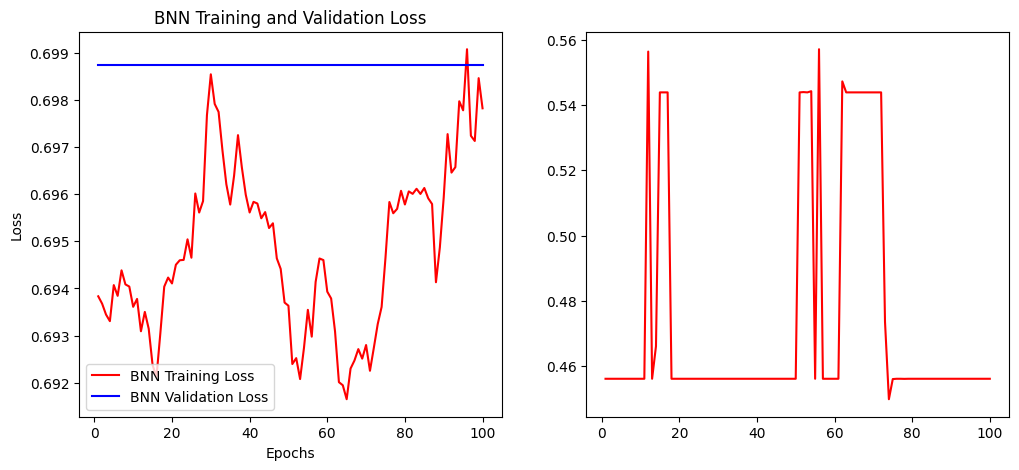

In [23]:
#  training loss and accuracy values for each epoch
epochs = range(1, len(bnn_training_losses) + 1)

# Ensure that bnn_val_loss has the same length as epochs
bnn_val_loss_plot = bnn_val_loss[:len(epochs)]

plt.figure(figsize=(12, 5))

# Plot BNN
plt.subplot(1, 2, 1)
plt.plot(epochs, bnn_training_losses, 'r', label='BNN Training Loss')
plt.plot(epochs, bnn_val_loss, 'b', label='BNN Validation Loss')
plt.title('BNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, bnn_training_accuracies, 'r', label='BNN Training Accuracy')
plt.plot(epochs, bnn_val_accuracy, 'b', label='BNN Validation Accuracy')
plt.title('BNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Learning Curve for RProp

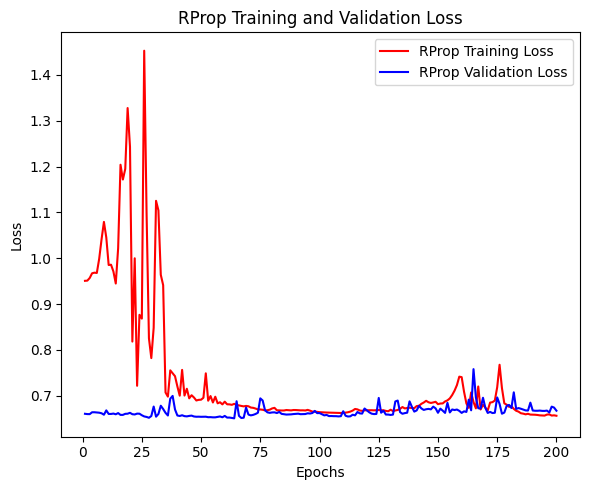

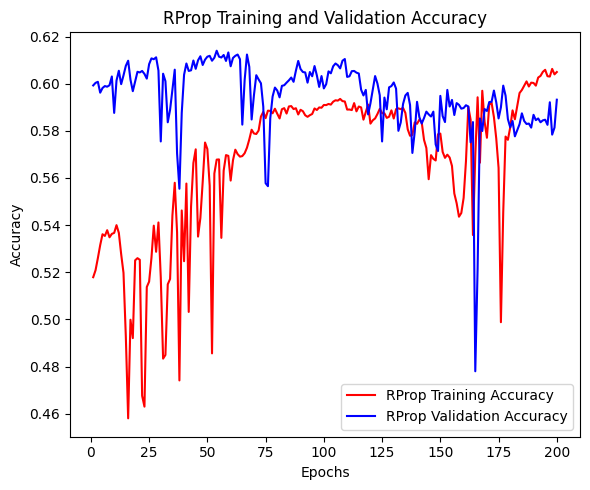

In [15]:
# training loss and accuracy values for each epoch
epochs = range(1, len(rprop_training_losses) + 1)

plt.figure(figsize=(6, 5))

# Plot RProp
plt.plot(epochs, rprop_training_losses, 'r', label='RProp Training Loss')
plt.plot(epochs, rprop_val_loss, 'b', label='RProp Validation Loss')
plt.title('RProp Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(epochs, rprop_training_accuracies, 'r', label='RProp Training Accuracy')
plt.plot(epochs, rprop_val_accuracy, 'b', label='RProp Validation Accuracy')
plt.title('RProp Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#  Compare BNN and Rprop Learning Curves

In [ ]:
plt.figure(figsize=(12, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, bnn_training_losses, 'r', label='BNN Training Loss')
plt.plot(epochs, bnn_val_loss, 'b', label='BNN Validation Loss')
plt.plot(epochs, rprop_training_losses, 'g', label='Rprop Training Loss')
plt.plot(epochs, rprop_val_loss, 'y', label='Rprop Validation Loss')
plt.title('BNN vs Rprop Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, bnn_training_accuracies, 'r', label='BNN Training Accuracy')
plt.plot(epochs, bnn_val_accuracy, 'b', label='BNN Validation Accuracy')
plt.plot(epochs, rprop_training_accuracies, 'g', label='Rprop Training Accuracy')
plt.plot(epochs, rprop_val_accuracy, 'y', label='Rprop Validation Accuracy')
plt.title('BNN vs Rprop Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# RProp Confusion Matrix


Rprop Metrics:
Precision: 0.5938
Recall: 0.3179
F1-score: 0.4141


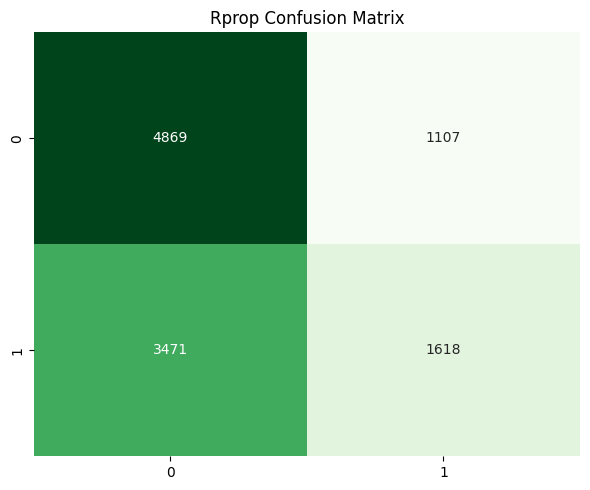

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


# Assuming your 'evaluate' method returns loss, accuracy, and predictions
rprop_loss, rprop_accuracy, rprop_predictions =rprop_nn.evaluate(x_test,y_test.reshape(-1,1))

# Threshold predictions for binary classification
binary_rprop_predictions = (rprop_predictions >= 0.5).astype(int)

# Calculate confusion matrix for Rprop
rprop_conf_matrix = confusion_matrix(y_test, binary_rprop_predictions)

# Calculate Precision, Recall, and F1-score for Rprop
rprop_precision = precision_score(y_test, binary_rprop_predictions)
rprop_recall = recall_score(y_test, binary_rprop_predictions)
rprop_f1 = f1_score(y_test, binary_rprop_predictions)

# Print the results for Rprop
print("\nRprop Metrics:")
print(f'Precision: {rprop_precision:.4f}')
print(f'Recall: {rprop_recall:.4f}')
print(f'F1-score: {rprop_f1:.4f}')

# Plot confusion matrix for Rprop
plt.figure(figsize=(6, 5))
sns.heatmap(rprop_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Rprop Confusion Matrix')
plt.tight_layout()
plt.show()


# BNN Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


# Assuming your 'evaluate' method returns loss, accuracy, and predictions
bnn_loss, bnn_accuracy, bnn_predictions = bnn.evaluate(x_test, y_test.reshape(-1, 1))

# Threshold predictions for binary classification
binary_bnn_predictions = (bnn_predictions >= 0.5).astype(int)

# Calculate confusion matrix for BNN
bnn_conf_matrix = confusion_matrix(y_test, binary_bnn_predictions)

# Calculate Precision, Recall, and F1-score for BNN
bnn_precision = precision_score(y_test, binary_bnn_predictions)
bnn_recall = recall_score(y_test, binary_bnn_predictions)
bnn_f1 = f1_score(y_test, binary_bnn_predictions)

# Print the results for BNN
print("BNN Metrics:")
print(f'Precision: {bnn_precision:.4f}')
print(f'Recall: {bnn_recall:.4f}')
print(f'F1-score: {bnn_f1:.4f}')

# Plot confusion matrix for BNN
plt.figure(figsize=(6, 5))
sns.heatmap(bnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('BNN Confusion Matrix')
plt.tight_layout()
plt.show()


#  ROC Curves

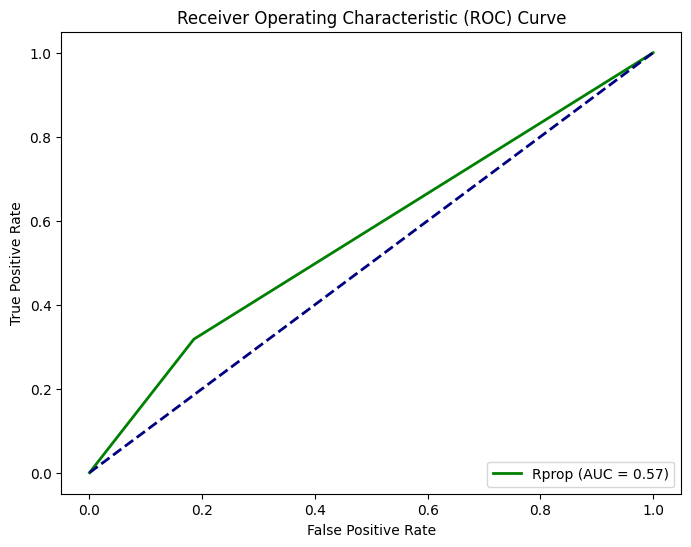

In [18]:
from sklearn.metrics import roc_curve, auc

# binary classification with labels and predicted probabilities for both BNN and Rprop models
fpr_bnn, tpr_bnn, _ = roc_curve(y_test, binary_bnn_predictions)
roc_auc_bnn = auc(fpr_bnn, tpr_bnn)

fpr_rprop, tpr_rprop, _ = roc_curve(y_test, binary_rprop_predictions)
roc_auc_rprop = auc(fpr_rprop, tpr_rprop)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bnn, tpr_bnn, color='darkorange', lw=2, label='BNN (AUC = %0.2f)' % roc_auc_bnn)
plt.plot(fpr_rprop, tpr_rprop, color='green', lw=2, label='Rprop (AUC = %0.2f)' % roc_auc_rprop)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()